In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=cuda, optimizer=None,exception_verbosity=high'

In [2]:
from keras import models

Using Theano backend.
Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'/tmp/try_flags_24_xznjr.c:4:19: fatal error: cudnn.h: No such file or directory\ncompilation terminated.\n'
Mapped name None to device cuda: Quadro M2000 (0000:02:00.0)


In [3]:
from keras.optimizers import SGD

In [4]:
path = './Data/'
img_w = 256
img_h = 256
n_labels = 2

n_train = 1010

In [5]:
n_test = 165


In [6]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map

In [7]:
def prep_data(mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv(path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [imread(path + item[0])], np.clip(imread(path + item[1]), 0, 1)
        data.append(img)
        gt2 = np.asarray(gt)
        
        label.append(label_map(gt2))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data), np.array(label).reshape((n, img_h * img_w, n_labels))

    print (mode + ': OK')
    print ('\tshapes: {}, {}'.format(data.shape, label.shape))
    print ('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print ('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [8]:
def plot_results(output):
    gt = []
    df = pd.read_csv(path + 'test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(path + item[1], as_gray=True), 0, 1))

    plt.figure(figsize=(15, 2 * n_test))
    thres = 0.5
    for i, item in df.iterrows():
        plt.subplot(n_test, 4, 4 * i + 1)
        plt.title('Ground Truth')
        plt.axis('off')
        gt = imread(path + item[1], as_gray=True)
        plt.imshow(np.clip(gt, 0, 1))

        plt.subplot(n_test, 4, 4 * i + 2)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(labeled)

        plt.subplot(n_test, 4, 4 * i + 3)
        plt.title('Heat map')
        plt.axis('off')
        plt.imshow(output[i][:, :, 1])

        plt.subplot(n_test, 4, 4 * i + 4)
        plt.title('Comparison')
        plt.axis('off')
        rgb = np.empty((img_h, img_w, 3))
        thresholded = labeled
        
        for i in range(0,256):
            for j in range(0,256):
                if(labeled[i][j]>thres):
                    thresholded[i][j]=1
                else:
                    thresholded[i][j]=0
        rgb[:, :, 0] = thresholded
        #print(item[0])
        
        rgb[:, :, 1] = imread(path+item[0],as_gray=True)
        rgb[:, :, 2] = gt
        plt.imshow(rgb)
        

    plt.savefig('result.png')
    plt.show()

In [9]:
with open('model_5l.json') as model_file:
    autoencoder = models.model_from_json(model_file.read())

optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print ('Compiled: OK')

Compiled: OK


In [11]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
__________

batch_normalization_19 (Batc (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_19 (Activation)   (None, 32, 32, 256)       0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 256)       590080    
_________________________________________________________________
batch_normalization_20 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
activation_20 (Activation)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 64, 64, 256)       590080    
_________________________________________________________________
batch_normalization_21 (Batc (None, 64, 64, 256)       1024      
__________

In [11]:
test_data, test_label = prep_data('test')
test_data = np.reshape(test_data,(test_data.shape[0], 256, 256, 3))
score = autoencoder.evaluate(test_data, test_label, verbose=0)
print ('Test score:', score[0])
print ('Test accuracy:', score[1])

test: OK==================>] 100%
	shapes: (165, 1, 256, 256, 3), (165, 65536, 2)
	types:  uint8, float64
	memory: 30.9375, 165.0 MB
Test score: 0.6932123097506436
Test accuracy: 0.5143247662168561


ValueError: num must be 1 <= num <= 12, not 13

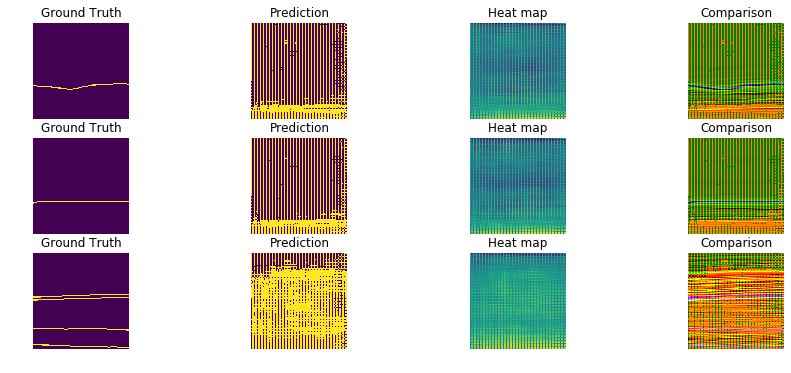

In [17]:
output = autoencoder.predict_proba(test_data, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

plot_results(output)

In [12]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
__________

batch_normalization_21 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
activation_21 (Activation)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 128)       295040    
_________________________________________________________________
batch_normalization_22 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
activation_22 (Activation)   (None, 64, 64, 128)       0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 128)     147584    
_________________________________________________________________
batch_normalization_23 (Batc (None, 128, 128, 128)     512       
__________